# State of Charge Battery Estimation Using Deep Learning

### Credit: Farhan Wily B.Sc

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers  
from keras_visualizer import visualizer 
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import sklearn
import math
from tensorflow.keras import layers
import time
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import keras as K

# DNN

### Training

In [11]:
df = pd.read_parquet('datatraining_20cyc.parquet')

In [12]:
df.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,1,2018-09-05 20:00:10.430,0.00,0.00,4.150365,-1.020517,26.1875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.232017,-0.000000,-0.000000,0.000000,0.0
1,1,2018-09-05 20:00:11.420,0.99,0.99,4.148910,-1.020517,26.1875,0.000281,0.000281,0.000281,0.0,0.001455,0.008254,99.991746,4.230562,-0.001187,-0.001187,0.001187,0.0
2,1,2018-09-05 20:00:12.400,1.97,0.98,4.147455,-1.020517,26.1875,0.000278,0.000558,0.000558,0.0,0.001455,0.016425,99.983575,4.229107,-0.001175,-0.002362,0.002362,0.0
3,1,2018-09-05 20:00:13.410,2.98,1.01,4.146000,-1.019106,26.1875,0.000286,0.000844,0.000844,0.0,0.001455,0.024834,99.975166,4.227539,-0.001209,-0.003571,0.003571,0.0
4,1,2018-09-05 20:00:14.400,3.97,0.99,4.145273,-1.021929,26.1875,0.000281,0.001125,0.001125,0.0,0.000727,0.033100,99.966900,4.227038,-0.001188,-0.004759,0.004759,0.0


In [13]:
X = df[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
x_values = np.array(X).reshape(-1, 4)
y = df['SOCref']
y_values = np.array(y).reshape(-1, 1)
from sklearn.model_selection import train_test_split
SAMPLES = len(df)
start = time.time()
with tf.device("/cpu:0"):
    TRAIN_SPLIT =  int(0.7 * SAMPLES)
    TEST_SPLIT = SAMPLES-TRAIN_SPLIT
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.30, random_state=42)
    model = tf.keras.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(4,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(56, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
    history=model.fit(x_train, y_train, epochs=100, batch_size=32,
    validation_data=(x_test, y_test), verbose=1)
    print("Waktu Training: ", time.time() - start, "seconds")
start = time.time()
with tf.device("/gpu:0"):
    predY=model.predict(x_test)
    print("Waktu Prediksi: ", time.time() - start, "seconds")

Epoch 1/100
11951/11951 [==============================] - 22s 2ms/step - loss: 13.3876 - mse: 13.3876 - mae: 1.0066 - mape: 15.6786 - val_loss: 0.0843 - val_mse: 0.0843 - val_mae: 0.2156 - val_mape: 5.4238
Epoch 2/100
11951/11951 [==============================] - 21s 2ms/step - loss: 0.1695 - mse: 0.1695 - mae: 0.3154 - mape: 6.1143 - val_loss: 0.0969 - val_mse: 0.0969 - val_mae: 0.2458 - val_mape: 5.0511
Epoch 3/100
11951/11951 [==============================] - 21s 2ms/step - loss: 0.1297 - mse: 0.1297 - mae: 0.2732 - mape: 5.6401 - val_loss: 0.0529 - val_mse: 0.0529 - val_mae: 0.1759 - val_mape: 4.3312
Epoch 4/100
11951/11951 [==============================] - 23s 2ms/step - loss: 0.1059 - mse: 0.1059 - mae: 0.2459 - mape: 5.5305 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1350 - val_mape: 4.5766
Epoch 5/100
11951/11951 [==============================] - 26s 2ms/step - loss: 0.0936 - mse: 0.0936 - mae: 0.2314 - mape: 5.2319 - val_loss: 0.0476 - val_mse: 0.0476 - val_mae: 0.1

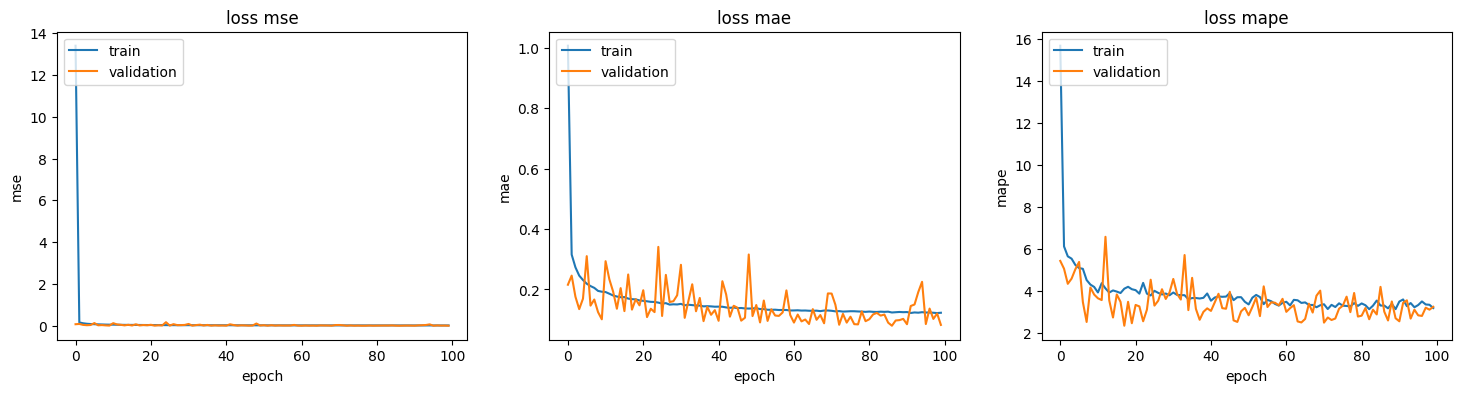

In [14]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['mse','mae', 'mape']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('loss {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

<Figure size 640x480 with 0 Axes>

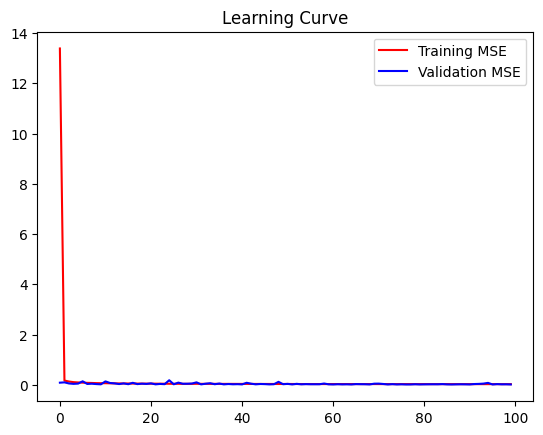

<Figure size 640x480 with 0 Axes>

In [15]:
mse = history.history['mse']
val_mse = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse))

plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Learning Curve')
plt.legend(loc=0)
plt.figure()

In [16]:
# Uji Performa
predY=model.predict(x_test)

r2=r2_score(y_test, predY)
mse = mean_squared_error(y_test,predY)
rmse=np.sqrt(mean_squared_error(y_test,predY))
MAE=mean_absolute_error(y_test, predY)
MAPE=mean_absolute_percentage_error(y_test, predY)

print('R2 data latih   =',r2)
print('RMSE data latih =',rmse)
print('MAE data latih  =',MAE)
print('MAPE data latih =',MAPE*100,'%')

5122/5122 [==============================] - 4s 759us/step
R2 data latih   = 0.9999852245605819
RMSE data latih = 0.11415504845958713
MAE data latih  = 0.08271900828396866
MAPE data latih = 3.2357450242251686 %


In [17]:
# Apply Model
SOC_val=model.predict(x_values)
df['SOC_pred']=SOC_val
df['Rel_Err']=(df['SOC_pred']-df['SOCref'])*100/df['SOCref']
df['Rel_Err']=df['Rel_Err'].abs()
df

17073/17073 [==============================] - 14s 801us/step


,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),...,deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh),SOC_pred,Rel_Err
0,1,2018-09-05 20:00:10.430,0.00,0.00,4.150365,-1.020517,26.1875,0.000000,0.000000,0.000000,...,0.000000,0.000000,100.000000,4.232017,-0.000000,-0.000000,0.000000,0.000000,100.356186,0.356186
1,1,2018-09-05 20:00:11.420,0.99,0.99,4.148910,-1.020517,26.1875,0.000281,0.000281,0.000281,...,0.001455,0.008254,99.991746,4.230562,-0.001187,-0.001187,0.001187,0.000000,100.338394,0.346677
2,1,2018-09-05 20:00:12.400,1.97,0.98,4.147455,-1.020517,26.1875,0.000278,0.000558,0.000558,...,0.001455,0.016425,99.983575,4.229107,-0.001175,-0.002362,0.002362,0.000000,100.320663,0.337144
3,1,2018-09-05 20:00:13.410,2.98,1.01,4.146000,-1.019106,26.1875,0.000286,0.000844,0.000844,...,0.001455,0.024834,99.975166,4.227539,-0.001209,-0.003571,0.003571,0.000000,100.301857,0.326772
4,1,2018-09-05 20:00:14.400,3.97,0.99,4.145273,-1.021929,26.1875,0.000281,0.001125,0.001125,...,0.000727,0.033100,99.966900,4.227038,-0.001188,-0.004759,0.004759,0.000000,100.291435,0.324643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546324,20,2018-09-06 03:15:40.160,25283.42,0.99,4.198270,0.220181,26.3125,0.000061,0.000273,3.389927,...,0.000364,0.008041,99.991959,4.188756,0.000254,0.205479,12.556753,12.762231,99.859741,0.132228
546325,20,2018-09-06 03:15:41.180,25284.44,1.02,4.197906,0.220181,26.3125,0.000062,0.000211,3.389927,...,0.000364,0.006206,99.993794,4.188392,0.000261,0.205740,12.556753,12.762493,99.859619,0.134183
546326,20,2018-09-06 03:15:42.170,25285.43,0.99,4.198270,0.220181,26.3125,0.000061,0.000150,3.389927,...,0.000364,0.004425,99.995575,4.188756,0.000254,0.205994,12.556753,12.762746,99.863350,0.132230
546327,20,2018-09-06 03:15:43.180,25286.44,1.01,4.198270,0.220181,26.3125,0.000062,0.000089,3.389927,...,0.000000,0.002609,99.997391,4.188756,0.000259,0.206253,12.556753,12.763005,99.865181,0.132214


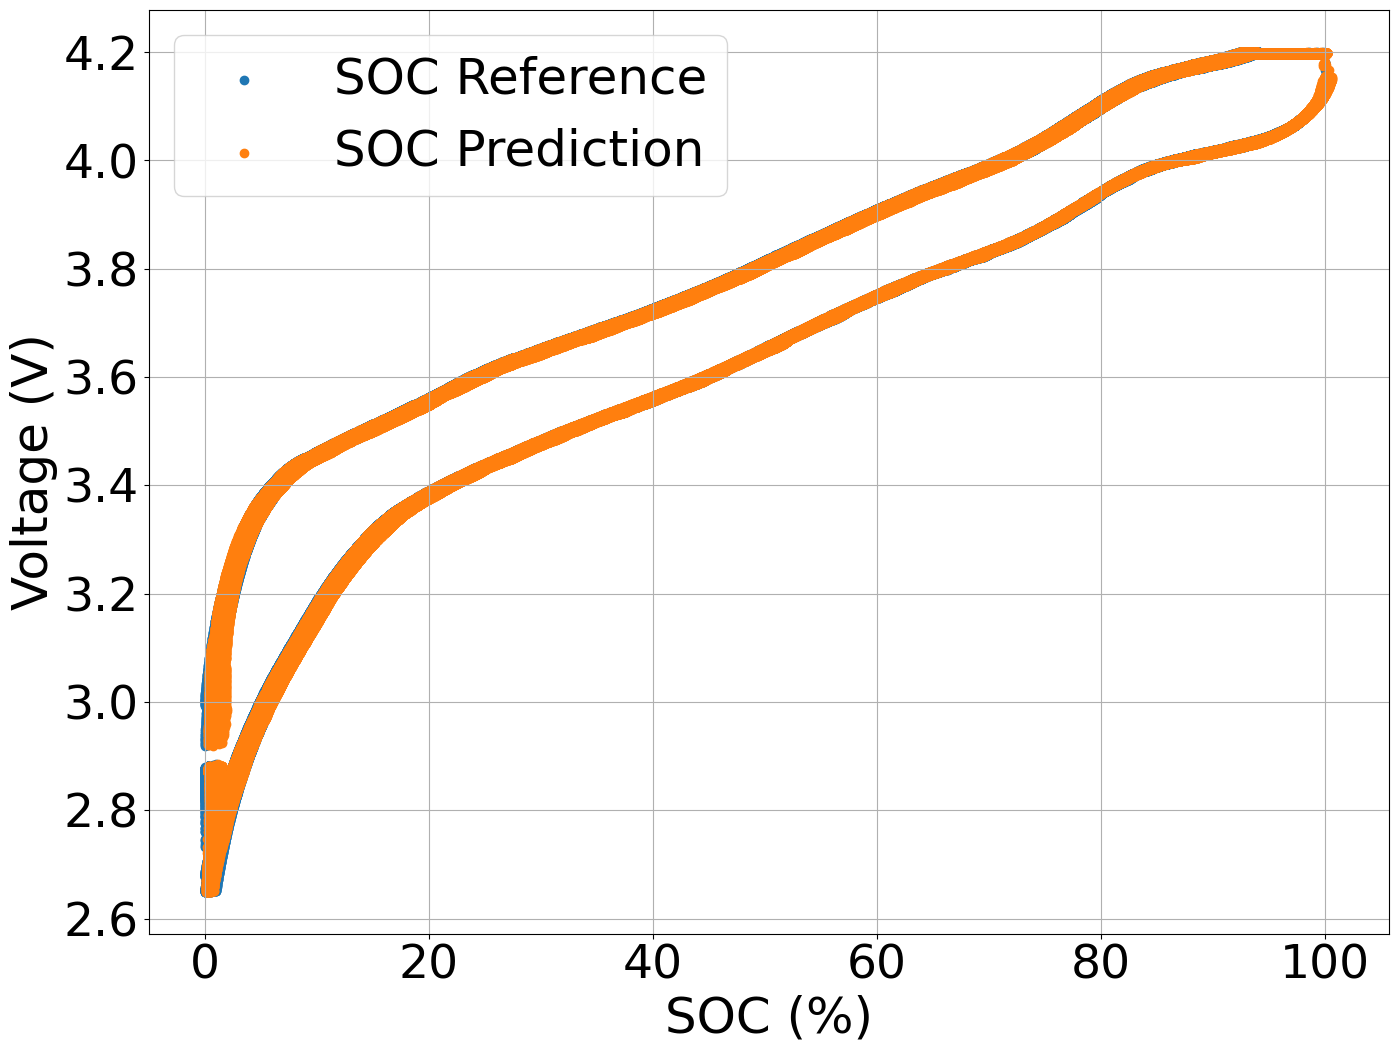

In [18]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(df['SOCref'],df['Voltage'])
plt.scatter(df['SOC_pred'],df['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [19]:
model.save('dnn_model3')

INFO:tensorflow:Assets written to: dnn_model3\assets


### Testing

In [20]:
dt = pd.read_parquet('datavalidasi_8cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,22,2019-03-21 21:58:07.150,0.00,0.00,4.150365,-1.020517,26.0625,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.238670,-0.000000,-0.000000,0.000000,0.0
1,22,2019-03-21 21:58:07.960,0.81,0.81,4.148546,-1.020517,26.0625,0.000230,0.000230,0.000230,0.0,0.001819,0.006753,99.993247,4.236852,-0.000973,-0.000973,0.000973,0.0
2,22,2019-03-21 21:58:08.150,1.00,0.19,4.148183,-1.020517,26.0625,0.000054,0.000283,0.000283,0.0,0.000364,0.008338,99.991662,4.236488,-0.000228,-0.001201,0.001201,0.0
3,22,2019-03-21 21:58:09.160,2.01,1.01,4.147092,-1.020517,26.0625,0.000286,0.000570,0.000570,0.0,0.001091,0.016758,99.983242,4.235397,-0.001213,-0.002414,0.002414,0.0
4,22,2019-03-21 21:58:10.160,3.01,1.00,4.146000,-1.020517,26.0625,0.000283,0.000853,0.000853,0.0,0.001091,0.025096,99.974904,4.234306,-0.001200,-0.003614,0.003614,0.0


In [21]:
from tensorflow.keras.models import load_model
model = load_model('dnn_model3')

In [22]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

6763/6763 [==============================] - 6s 847us/step


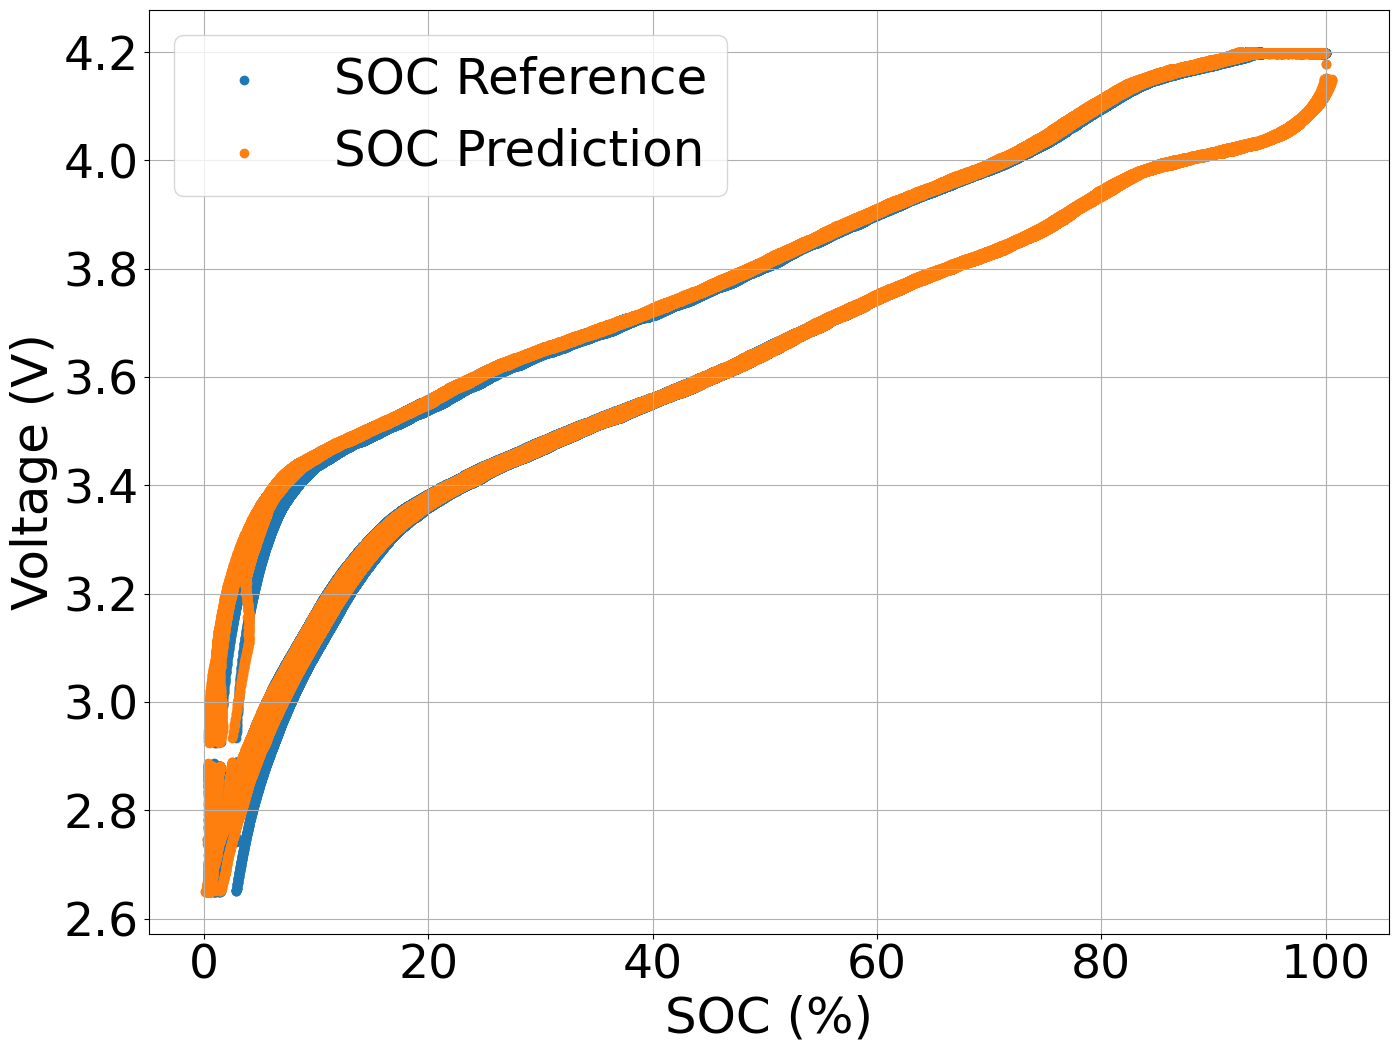

In [23]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCref'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [24]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.999798872474357
RMSE data tes = 0.41837792376338645
MAE  data tes = 0.2780648571746103
MAPE data tes = 1.6877414984364465 %


# Validasi 2

In [25]:
dt = pd.read_parquet('datavalidasi2_1cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh),SOCnorm
0,1,2018-09-06 03:41:33.220,0.00,0.00,4.170733,-0.340172,26.1875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.197950,-0.000000,-0.000000,0.000000,0.0,100.000000
1,1,2018-09-06 03:41:34.240,1.02,1.02,4.170006,-0.340172,26.1875,0.000096,0.000096,0.000096,0.0,0.000727,0.002835,99.997165,4.197223,-0.000405,-0.000405,0.000405,0.0,99.997185
2,1,2018-09-06 03:41:35.240,2.02,1.00,4.169278,-0.340172,26.1875,0.000094,0.000191,0.000191,0.0,0.000727,0.005614,99.994386,4.196496,-0.000397,-0.000801,0.000801,0.0,99.994425
3,1,2018-09-06 03:41:36.220,3.00,0.98,4.168915,-0.340172,26.1875,0.000093,0.000283,0.000283,0.0,0.000364,0.008338,99.991662,4.196132,-0.000389,-0.001190,0.001190,0.0,99.991720
4,1,2018-09-06 03:41:37.240,4.02,1.02,4.168551,-0.340172,26.1875,0.000096,0.000380,0.000380,0.0,0.000364,0.011172,99.988828,4.195768,-0.000404,-0.001594,0.001594,0.0,99.988905


In [26]:
from tensorflow.keras.models import load_model
model = load_model('dnn_model3')

In [27]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

2503/2503 [==============================] - 2s 893us/step


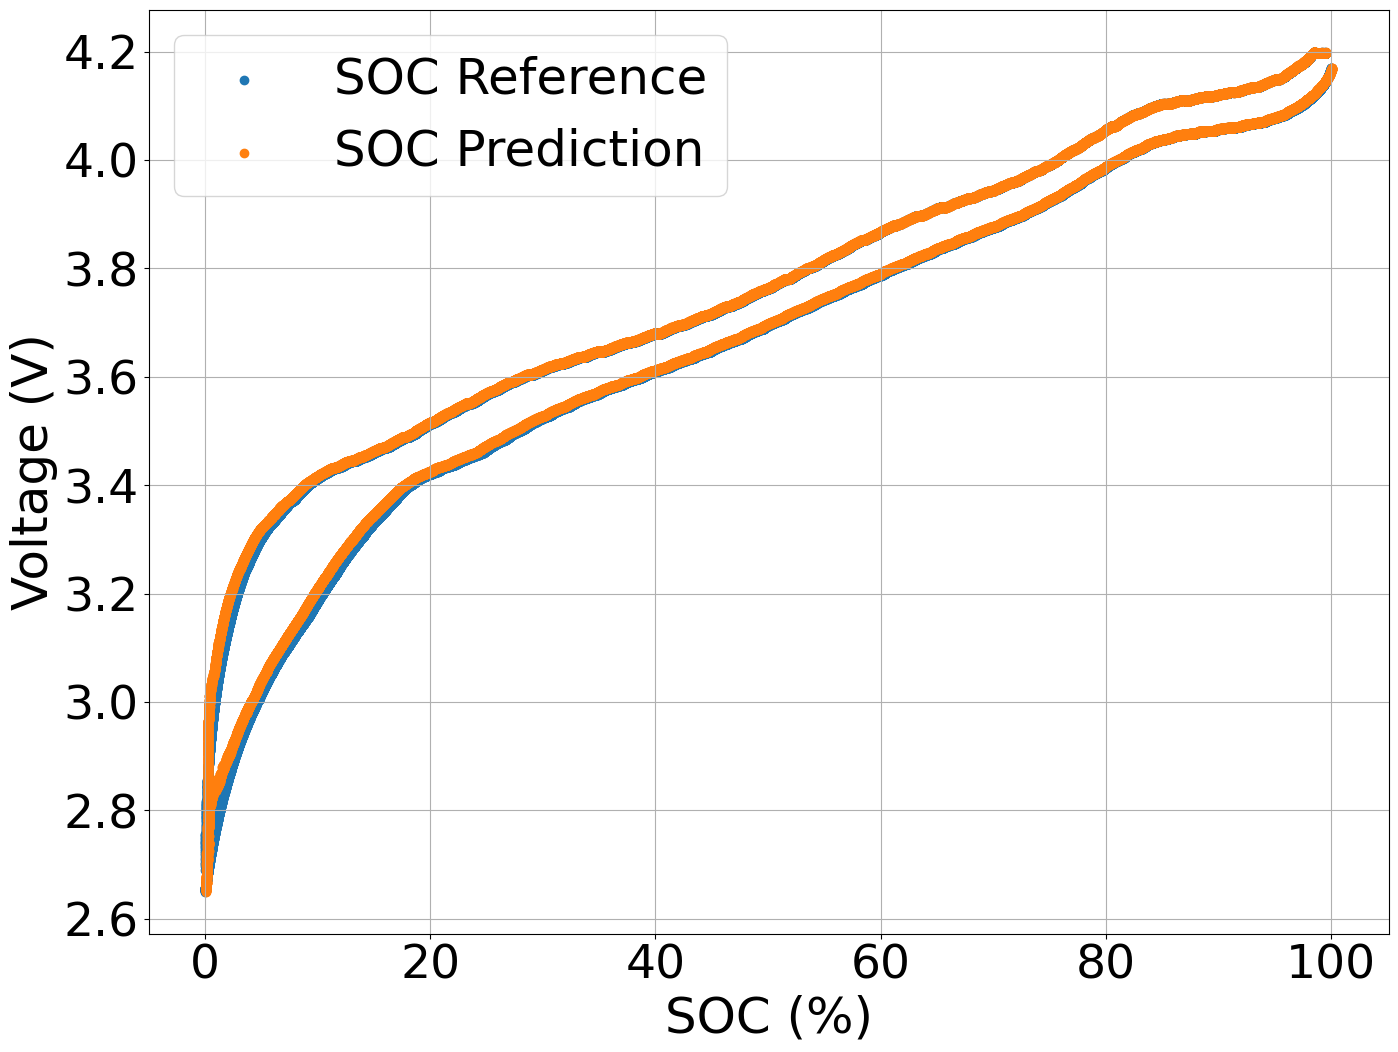

In [28]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCnorm'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [29]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9999689546673206
RMSE data tes = 0.16245738131420523
MAE  data tes = 0.12651385795453363
MAPE data tes = 8.85156055476817 %


# Validasi 3

In [30]:
dt = pd.read_parquet('datavalidasi3_1cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,1,2018-09-17 11:17:37.170,0.00,0.00,4.043151,0.869627,26.25,0.000000,0.000000,2.573356,2.573356,0.000000,0.000000,100.000000,4.005922,0.000000,0.000000,9.737424,9.737424
1,1,2018-09-17 11:17:37.180,0.01,0.01,4.040241,0.765159,26.25,0.000002,0.000002,2.573356,2.573358,0.002909,0.000063,100.000063,4.007485,0.000009,0.000009,9.737424,9.737432
2,1,2018-09-17 11:17:37.200,0.03,0.02,4.040241,0.765159,26.25,0.000004,0.000006,2.573356,2.573363,0.000000,0.000188,100.000188,4.007485,0.000017,0.000026,9.737424,9.737449
3,1,2018-09-17 11:17:37.270,0.10,0.07,4.047878,1.061622,26.25,0.000021,0.000027,2.573356,2.573383,0.007637,0.000795,100.000795,4.002430,0.000083,0.000108,9.737424,9.737532
4,1,2018-09-17 11:17:37.360,0.19,0.09,4.041696,0.804687,26.25,0.000020,0.000047,2.573356,2.573403,0.006182,0.001386,100.001386,4.007247,0.000081,0.000189,9.737424,9.737613


In [31]:
from tensorflow.keras.models import load_model
model = load_model('dnn_model3')

In [32]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

1232/1232 [==============================] - 1s 811us/step


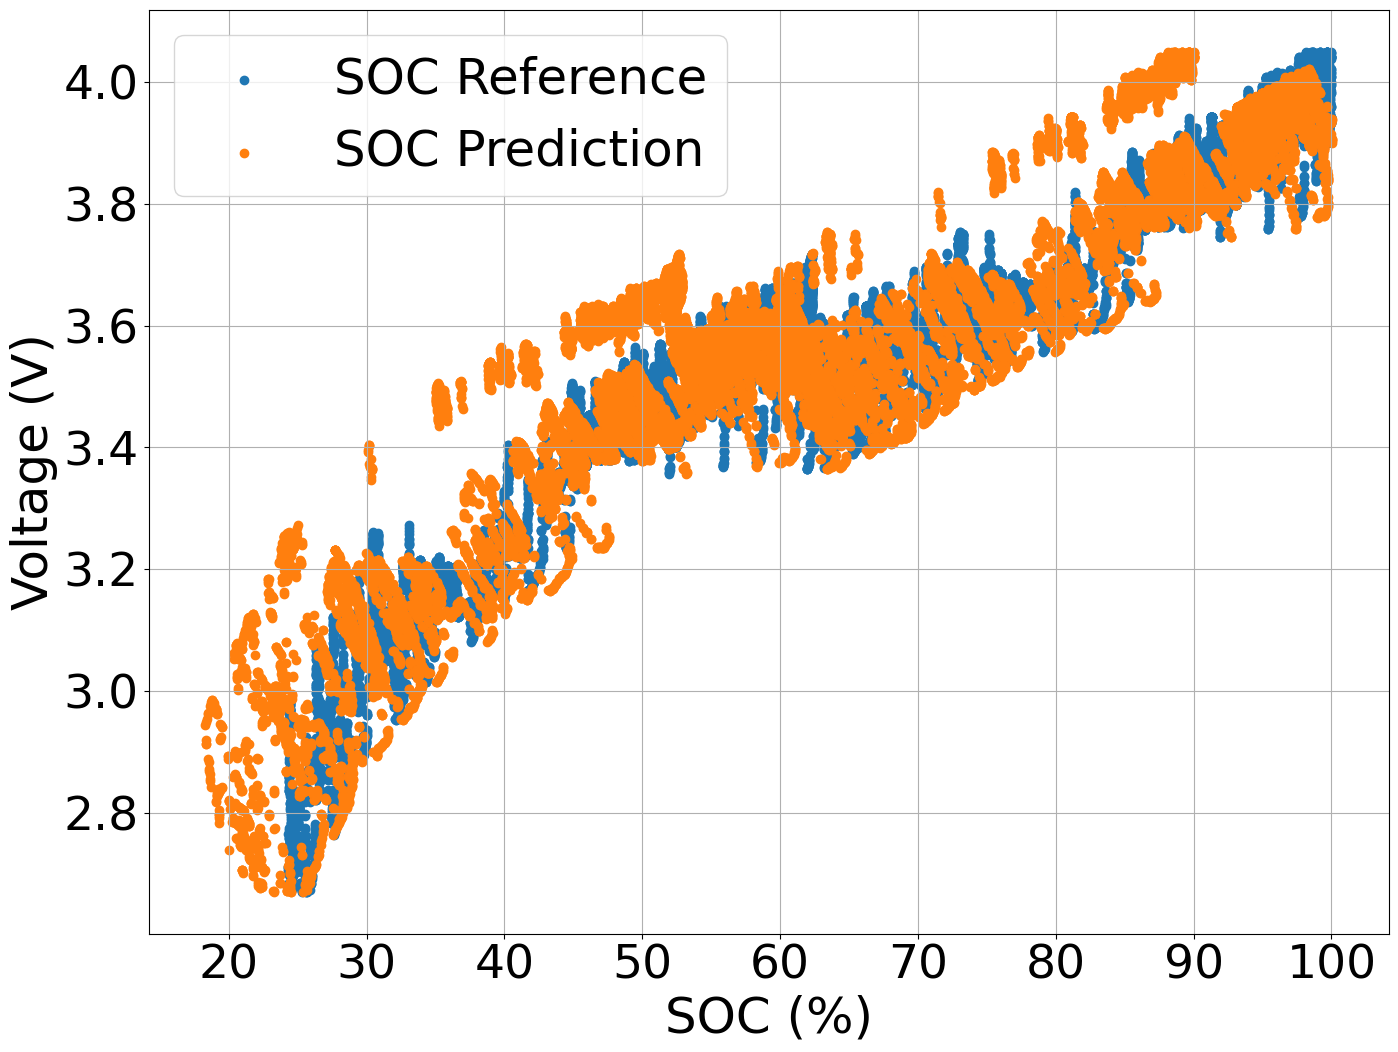

In [33]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCref'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [34]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9559803234625278
RMSE data tes = 4.39117779222858
MAE  data tes = 2.8393782448591467
MAPE data tes = 4.577562890177447 %


# Recurrent Neural Network

### Training

In [35]:
df = pd.read_parquet('datatraining_20cyc.parquet')

In [36]:
df.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,1,2018-09-05 20:00:10.430,0.00,0.00,4.150365,-1.020517,26.1875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.232017,-0.000000,-0.000000,0.000000,0.0
1,1,2018-09-05 20:00:11.420,0.99,0.99,4.148910,-1.020517,26.1875,0.000281,0.000281,0.000281,0.0,0.001455,0.008254,99.991746,4.230562,-0.001187,-0.001187,0.001187,0.0
2,1,2018-09-05 20:00:12.400,1.97,0.98,4.147455,-1.020517,26.1875,0.000278,0.000558,0.000558,0.0,0.001455,0.016425,99.983575,4.229107,-0.001175,-0.002362,0.002362,0.0
3,1,2018-09-05 20:00:13.410,2.98,1.01,4.146000,-1.019106,26.1875,0.000286,0.000844,0.000844,0.0,0.001455,0.024834,99.975166,4.227539,-0.001209,-0.003571,0.003571,0.0
4,1,2018-09-05 20:00:14.400,3.97,0.99,4.145273,-1.021929,26.1875,0.000281,0.001125,0.001125,0.0,0.000727,0.033100,99.966900,4.227038,-0.001188,-0.004759,0.004759,0.0


In [37]:
X = df[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
x_values = np.array(X).reshape(-1, 1, 4)
y = df['SOCref']
y_values = np.array(y).reshape(-1, 1)
from sklearn.model_selection import train_test_split
SAMPLES = len(df)
start = time.time()
with tf.device("/cpu:0"):
    TRAIN_SPLIT =  int(0.7 * SAMPLES)
    TEST_SPLIT = SAMPLES-TRAIN_SPLIT
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.30, random_state=42)
    model = tf.keras.Sequential()
    model.add(layers.SimpleRNN(32, activation='relu', input_shape=(1, 4), return_sequences=True))
    model.add(layers.SimpleRNN(48, activation='relu', return_sequences=True))
    model.add(layers.SimpleRNN(56, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    print(model.summary())
    print('\n')
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
    history=model.fit(x_train, y_train, epochs=100, batch_size=32,
    validation_data=(x_test, y_test))
    print("Waktu Training: ", time.time() - start, "seconds")
start = time.time()
with tf.device("/gpu:0"):
    predY=model.predict(x_test)
    print("Waktu Prediksi: ", time.time() - start, "seconds")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 32)             1184      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 48)             3888      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 56)                5880      
                                                                 
 dense_14 (Dense)            (None, 1)                 57        
                                                                 
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
11951/11951 [==============================] - 39s 3ms/step - loss: 20.5324 - mse: 20.5324 - mae: 1.1198 - mape: 14.1997 - val_loss: 0.2212 - val_mse: 0.2212 - val

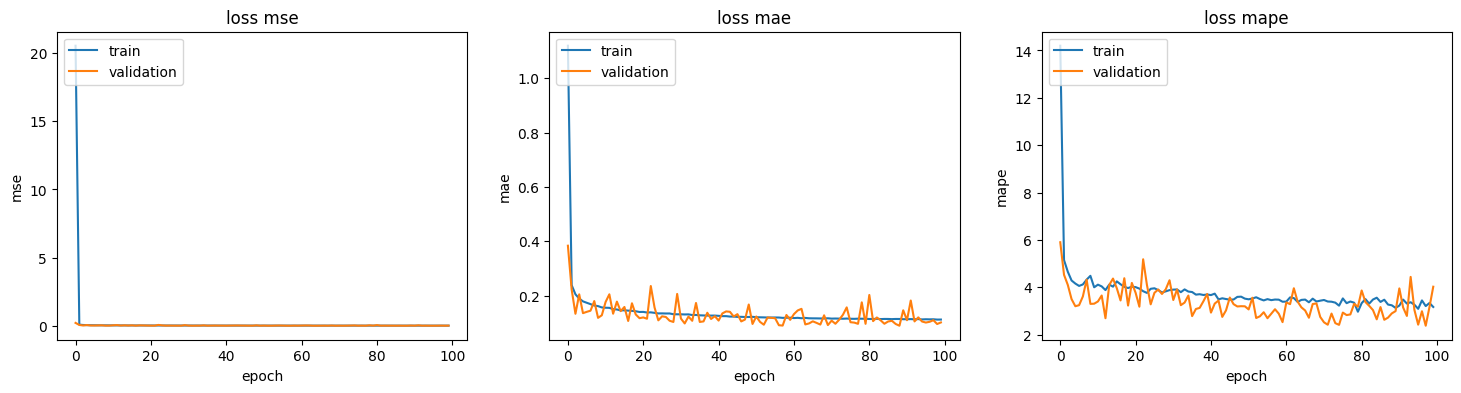

In [38]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['mse','mae', 'mape']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('loss {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

<Figure size 640x480 with 0 Axes>

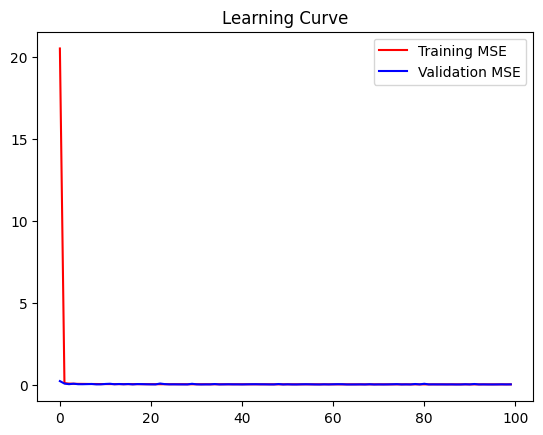

<Figure size 640x480 with 0 Axes>

In [39]:
mse = history.history['mse']
val_mse = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse))

plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Learning Curve')
plt.legend(loc=0)
plt.figure()

In [41]:
# Uji Performa
predY=model.predict(x_test)

r2=r2_score(y_test, predY)
mse = mean_squared_error(y_test,predY)
rmse=np.sqrt(mean_squared_error(y_test,predY))
MAE=mean_absolute_error(y_test, predY)
MAPE=mean_absolute_percentage_error(y_test, predY)

print('R2 data latih   =',r2)
print('RMSE data latih =',rmse)
print('MAE data latih  =',MAE)
print('MAPE data latih =',MAPE*100,'%')

5122/5122 [==============================] - 6s 1ms/step
R2 data latih   = 0.999976668774157
RMSE data latih = 0.1434477361627413
MAE data latih  = 0.10168418449850293
MAPE data latih = 4.027356779077965 %


In [42]:
# Apply Model
SOC_val=model.predict(x_values)
df['SOC_pred']=SOC_val
df['Rel_Err']=(df['SOC_pred']-df['SOCref'])*100/df['SOCref']
df['Rel_Err']=df['Rel_Err'].abs()
df

17073/17073 [==============================] - 19s 1ms/step


,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),...,deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh),SOC_pred,Rel_Err
0,1,2018-09-05 20:00:10.430,0.00,0.00,4.150365,-1.020517,26.1875,0.000000,0.000000,0.000000,...,0.000000,0.000000,100.000000,4.232017,-0.000000,-0.000000,0.000000,0.000000,100.274826,0.274826
1,1,2018-09-05 20:00:11.420,0.99,0.99,4.148910,-1.020517,26.1875,0.000281,0.000281,0.000281,...,0.001455,0.008254,99.991746,4.230562,-0.001187,-0.001187,0.001187,0.000000,100.252365,0.260641
2,1,2018-09-05 20:00:12.400,1.97,0.98,4.147455,-1.020517,26.1875,0.000278,0.000558,0.000558,...,0.001455,0.016425,99.983575,4.229107,-0.001175,-0.002362,0.002362,0.000000,100.228973,0.245439
3,1,2018-09-05 20:00:13.410,2.98,1.01,4.146000,-1.019106,26.1875,0.000286,0.000844,0.000844,...,0.001455,0.024834,99.975166,4.227539,-0.001209,-0.003571,0.003571,0.000000,100.204041,0.228932
4,1,2018-09-05 20:00:14.400,3.97,0.99,4.145273,-1.021929,26.1875,0.000281,0.001125,0.001125,...,0.000727,0.033100,99.966900,4.227038,-0.001188,-0.004759,0.004759,0.000000,100.192108,0.225283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546324,20,2018-09-06 03:15:40.160,25283.42,0.99,4.198270,0.220181,26.3125,0.000061,0.000273,3.389927,...,0.000364,0.008041,99.991959,4.188756,0.000254,0.205479,12.556753,12.762231,99.855553,0.136417
546325,20,2018-09-06 03:15:41.180,25284.44,1.02,4.197906,0.220181,26.3125,0.000062,0.000211,3.389927,...,0.000364,0.006206,99.993794,4.188392,0.000261,0.205740,12.556753,12.762493,99.855217,0.138585
546326,20,2018-09-06 03:15:42.170,25285.43,0.99,4.198270,0.220181,26.3125,0.000061,0.000150,3.389927,...,0.000364,0.004425,99.995575,4.188756,0.000254,0.205994,12.556753,12.762746,99.859100,0.136480
546327,20,2018-09-06 03:15:43.180,25286.44,1.01,4.198270,0.220181,26.3125,0.000062,0.000089,3.389927,...,0.000000,0.002609,99.997391,4.188756,0.000259,0.206253,12.556753,12.763005,99.860886,0.136509


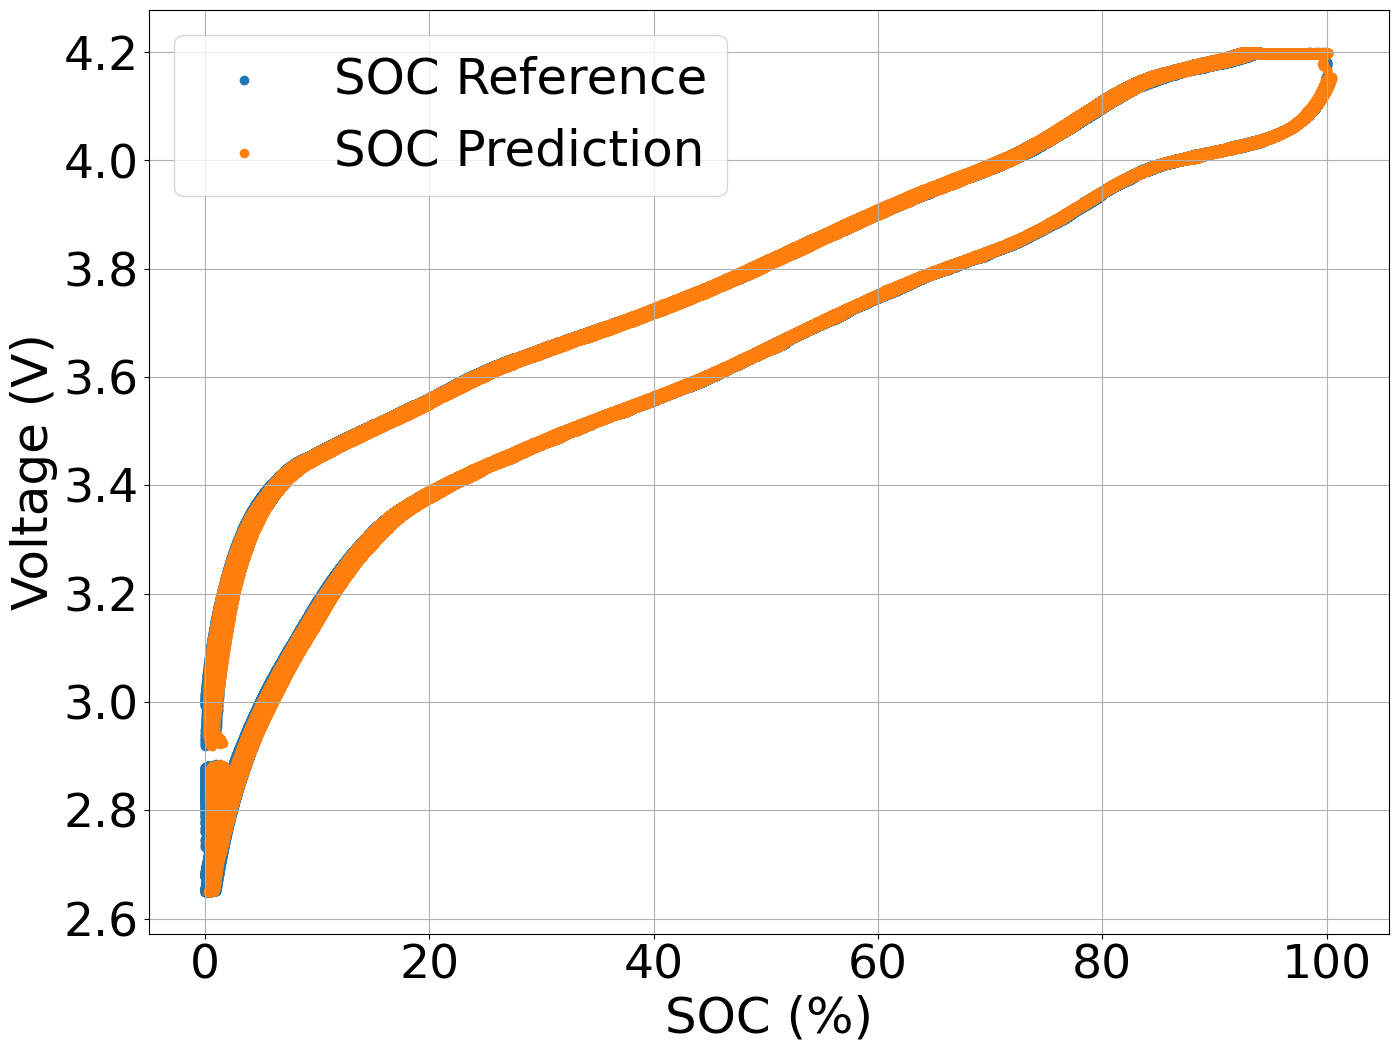

In [43]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(df['SOCref'],df['Voltage'])
plt.scatter(df['SOC_pred'],df['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [44]:
model.save('rnn_model3')

INFO:tensorflow:Assets written to: rnn_model3\assets


### Testing

In [45]:
dt = pd.read_parquet('datavalidasi_8cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,22,2019-03-21 21:58:07.150,0.00,0.00,4.150365,-1.020517,26.0625,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.238670,-0.000000,-0.000000,0.000000,0.0
1,22,2019-03-21 21:58:07.960,0.81,0.81,4.148546,-1.020517,26.0625,0.000230,0.000230,0.000230,0.0,0.001819,0.006753,99.993247,4.236852,-0.000973,-0.000973,0.000973,0.0
2,22,2019-03-21 21:58:08.150,1.00,0.19,4.148183,-1.020517,26.0625,0.000054,0.000283,0.000283,0.0,0.000364,0.008338,99.991662,4.236488,-0.000228,-0.001201,0.001201,0.0
3,22,2019-03-21 21:58:09.160,2.01,1.01,4.147092,-1.020517,26.0625,0.000286,0.000570,0.000570,0.0,0.001091,0.016758,99.983242,4.235397,-0.001213,-0.002414,0.002414,0.0
4,22,2019-03-21 21:58:10.160,3.01,1.00,4.146000,-1.020517,26.0625,0.000283,0.000853,0.000853,0.0,0.001091,0.025096,99.974904,4.234306,-0.001200,-0.003614,0.003614,0.0


In [46]:
from tensorflow.keras.models import load_model
model = load_model('rnn_model3')

In [48]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

6763/6763 [==============================] - 8s 1ms/step


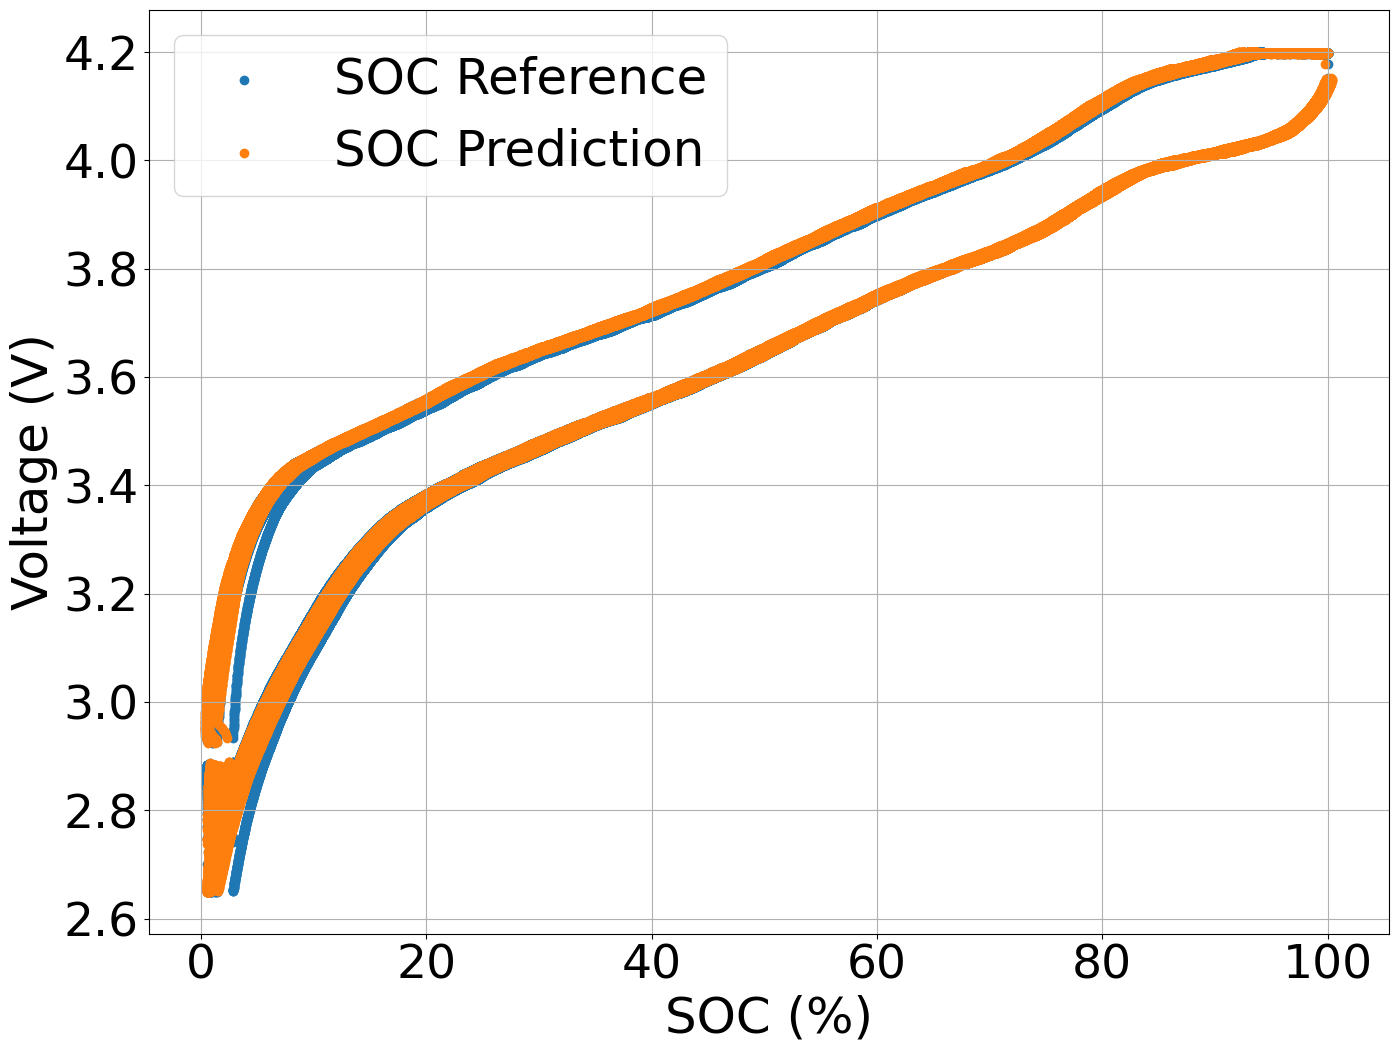

In [49]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCref'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [51]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9997550317072634
RMSE data tes = 0.4617298403358096
MAE  data tes = 0.31366715928109357
MAPE data tes = 1.7227032352719898 %


# Validasi 2

In [52]:
dt = pd.read_parquet('datavalidasi2_1cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh),SOCnorm
0,1,2018-09-06 03:41:33.220,0.00,0.00,4.170733,-0.340172,26.1875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.197950,-0.000000,-0.000000,0.000000,0.0,100.000000
1,1,2018-09-06 03:41:34.240,1.02,1.02,4.170006,-0.340172,26.1875,0.000096,0.000096,0.000096,0.0,0.000727,0.002835,99.997165,4.197223,-0.000405,-0.000405,0.000405,0.0,99.997185
2,1,2018-09-06 03:41:35.240,2.02,1.00,4.169278,-0.340172,26.1875,0.000094,0.000191,0.000191,0.0,0.000727,0.005614,99.994386,4.196496,-0.000397,-0.000801,0.000801,0.0,99.994425
3,1,2018-09-06 03:41:36.220,3.00,0.98,4.168915,-0.340172,26.1875,0.000093,0.000283,0.000283,0.0,0.000364,0.008338,99.991662,4.196132,-0.000389,-0.001190,0.001190,0.0,99.991720
4,1,2018-09-06 03:41:37.240,4.02,1.02,4.168551,-0.340172,26.1875,0.000096,0.000380,0.000380,0.0,0.000364,0.011172,99.988828,4.195768,-0.000404,-0.001594,0.001594,0.0,99.988905


In [53]:
from tensorflow.keras.models import load_model
model = load_model('rnn_model3')

In [54]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

2503/2503 [==============================] - 3s 1ms/step


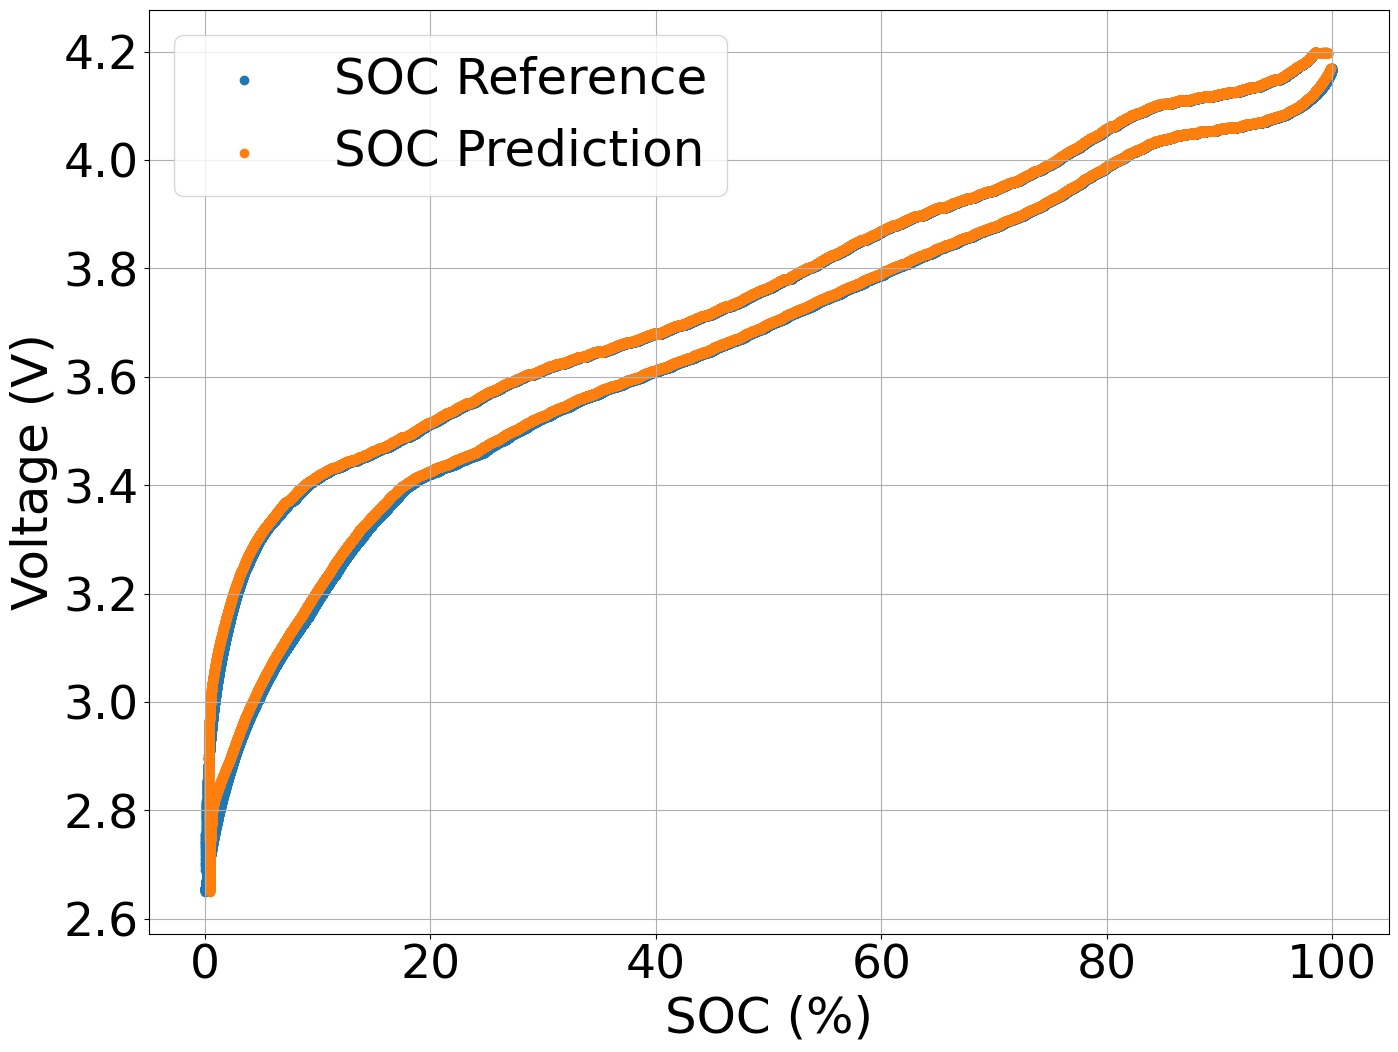

In [55]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCnorm'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [56]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9999712951499742
RMSE data tes = 0.15621363219967477
MAE  data tes = 0.11532763524307935
MAPE data tes = 12.12746231493792 %


# Validasi 3

In [57]:
dt = pd.read_parquet('datavalidasi3_1cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,1,2018-09-17 11:17:37.170,0.00,0.00,4.043151,0.869627,26.25,0.000000,0.000000,2.573356,2.573356,0.000000,0.000000,100.000000,4.005922,0.000000,0.000000,9.737424,9.737424
1,1,2018-09-17 11:17:37.180,0.01,0.01,4.040241,0.765159,26.25,0.000002,0.000002,2.573356,2.573358,0.002909,0.000063,100.000063,4.007485,0.000009,0.000009,9.737424,9.737432
2,1,2018-09-17 11:17:37.200,0.03,0.02,4.040241,0.765159,26.25,0.000004,0.000006,2.573356,2.573363,0.000000,0.000188,100.000188,4.007485,0.000017,0.000026,9.737424,9.737449
3,1,2018-09-17 11:17:37.270,0.10,0.07,4.047878,1.061622,26.25,0.000021,0.000027,2.573356,2.573383,0.007637,0.000795,100.000795,4.002430,0.000083,0.000108,9.737424,9.737532
4,1,2018-09-17 11:17:37.360,0.19,0.09,4.041696,0.804687,26.25,0.000020,0.000047,2.573356,2.573403,0.006182,0.001386,100.001386,4.007247,0.000081,0.000189,9.737424,9.737613


In [58]:
from tensorflow.keras.models import load_model
model = load_model('rnn_model3')

In [59]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

1232/1232 [==============================] - 2s 1ms/step


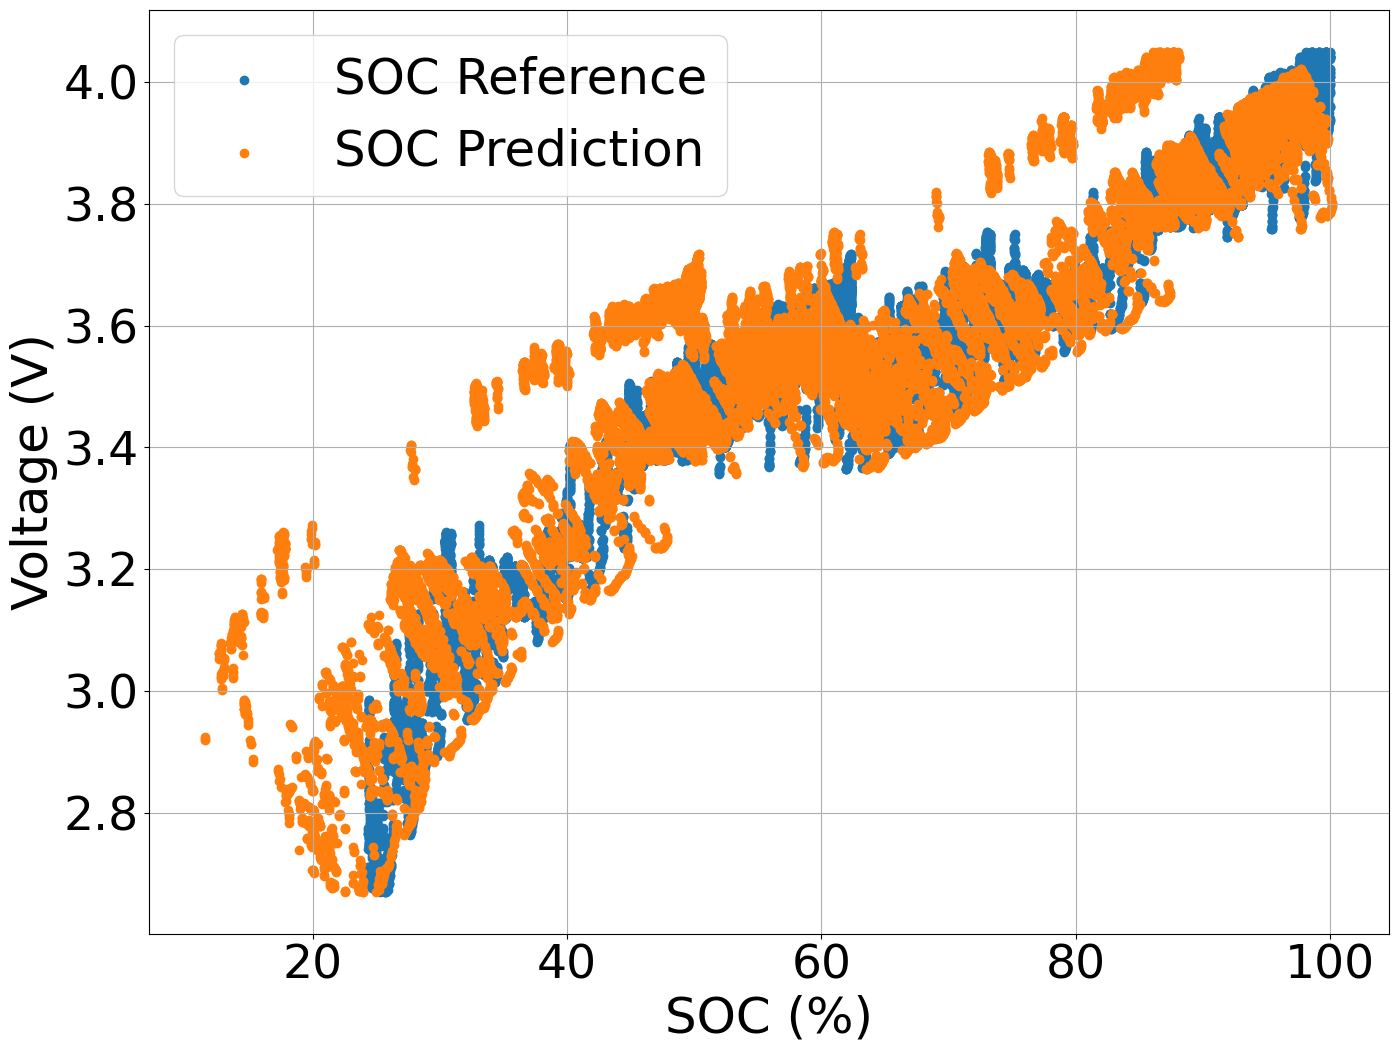

In [60]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCref'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [61]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9317981488382908
RMSE data tes = 5.465824452453641
MAE  data tes = 3.5212459846578112
MAPE data tes = 5.775538280535542 %


# Long-Short Term Memory

### Training

In [2]:
df = pd.read_parquet('datatraining_20cyc.parquet')

In [3]:
df.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,1,2018-09-05 20:00:10.430,0.00,0.00,4.150365,-1.020517,26.1875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.232017,-0.000000,-0.000000,0.000000,0.0
1,1,2018-09-05 20:00:11.420,0.99,0.99,4.148910,-1.020517,26.1875,0.000281,0.000281,0.000281,0.0,0.001455,0.008254,99.991746,4.230562,-0.001187,-0.001187,0.001187,0.0
2,1,2018-09-05 20:00:12.400,1.97,0.98,4.147455,-1.020517,26.1875,0.000278,0.000558,0.000558,0.0,0.001455,0.016425,99.983575,4.229107,-0.001175,-0.002362,0.002362,0.0
3,1,2018-09-05 20:00:13.410,2.98,1.01,4.146000,-1.019106,26.1875,0.000286,0.000844,0.000844,0.0,0.001455,0.024834,99.975166,4.227539,-0.001209,-0.003571,0.003571,0.0
4,1,2018-09-05 20:00:14.400,3.97,0.99,4.145273,-1.021929,26.1875,0.000281,0.001125,0.001125,0.0,0.000727,0.033100,99.966900,4.227038,-0.001188,-0.004759,0.004759,0.0


In [4]:
X = df[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
x_values = np.array(X).reshape(-1, 1, 4)
y = df['SOCref']
y_values = np.array(y).reshape(-1, 1)
from sklearn.model_selection import train_test_split
SAMPLES = len(df)
start = time.time()
with tf.device("/cpu:0"):
    TRAIN_SPLIT =  int(0.7 * SAMPLES)
    TEST_SPLIT = SAMPLES-TRAIN_SPLIT
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.30, random_state=42)
    model = tf.keras.Sequential()
    model.add(layers.LSTM(32, activation='relu', input_shape=(1, 4), return_sequences=True))
    model.add(layers.LSTM(48, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    print(model.summary())
    print('\n')
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
    history=model.fit(x_train, y_train, epochs=100, batch_size=32,
    validation_data=(x_test, y_test))
    print("Waktu Training: ", time.time() - start, "seconds")
start = time.time()
with tf.device("/gpu:0"):
    predY=model.predict(x_test)
    print("Waktu Prediksi: ", time.time() - start, "seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4736      
                                                                 
 lstm_1 (LSTM)               (None, 48)                15552     
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 20,337
Trainable params: 20,337
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
11951/11951 [==============================] - 43s 3ms/step - loss: 22.1935 - mse: 22.1935 - mae: 0.8880 - mape: 14.9707 - val_loss: 0.0564 - val_mse: 0.0564 - val_mae: 0.1756 - val_mape: 3.4933
Epoch 2/100
11951/11951 [==============================] - 40s 3ms/step - loss: 0.0656 - mse: 0.0656 -

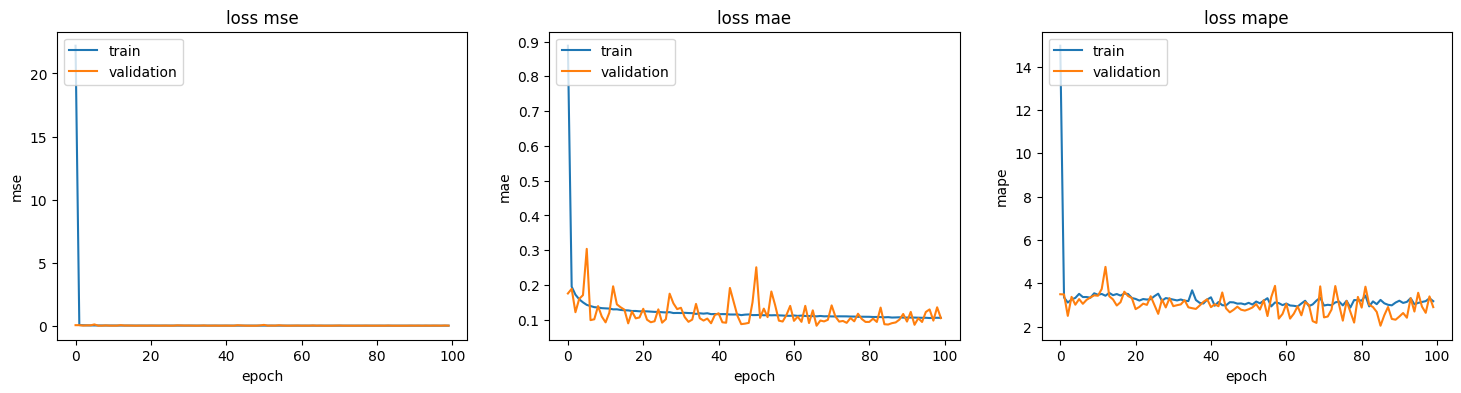

In [5]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
metric=['mse','mae', 'mape']
for i in range(3):
    ax[i].plot(history.history['{}'.format(metric[i])])
    ax[i].plot(history.history['val_{}'.format(metric[i])])
    ax[i].set_title('loss {}'.format(metric[i]))
    ax[i].set_ylabel('{}'.format(metric[i]))
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'validation'], loc='upper left')

<Figure size 640x480 with 0 Axes>

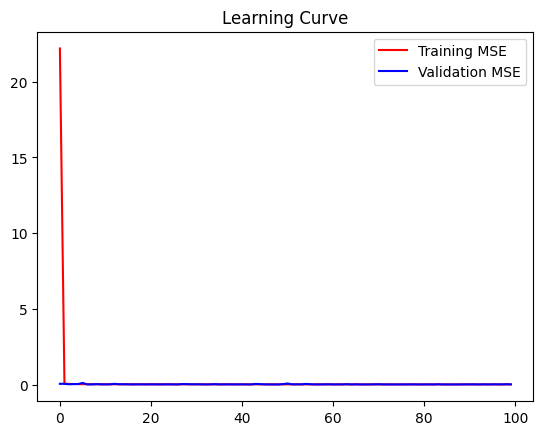

<Figure size 640x480 with 0 Axes>

In [6]:
mse = history.history['mse']
val_mse = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse))

plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Learning Curve')
plt.legend(loc=0)
plt.figure()

In [7]:
# Uji Performa
predY=model.predict(x_test)

r2=r2_score(y_test, predY)
mse = mean_squared_error(y_test,predY)
rmse=np.sqrt(mean_squared_error(y_test,predY))
MAE=mean_absolute_error(y_test, predY)
MAPE=mean_absolute_percentage_error(y_test, predY)

print('R2 data latih   =',r2)
print('RMSE data latih =',rmse)
print('MAE data latih  =',MAE)
print('MAPE data latih =',MAPE*100,'%')

5122/5122 [==============================] - 7s 1ms/step
R2 data latih   = 0.9999791876855089
RMSE data latih = 0.13548309521451024
MAE data latih  = 0.10476375328505447
MAPE data latih = 2.8974462514962216 %


In [8]:
# Apply Model
SOC_val=model.predict(x_values)
df['SOC_pred']=SOC_val
df['Rel_Err']=(df['SOC_pred']-df['SOCref'])*100/df['SOCref']
df['Rel_Err']=df['Rel_Err'].abs()
df

17073/17073 [==============================] - 22s 1ms/step


,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),...,deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh),SOC_pred,Rel_Err
0,1,2018-09-05 20:00:10.430,0.00,0.00,4.150365,-1.020517,26.1875,0.000000,0.000000,0.000000,...,0.000000,0.000000,100.000000,4.232017,-0.000000,-0.000000,0.000000,0.000000,99.915932,0.084068
1,1,2018-09-05 20:00:11.420,0.99,0.99,4.148910,-1.020517,26.1875,0.000281,0.000281,0.000281,...,0.001455,0.008254,99.991746,4.230562,-0.001187,-0.001187,0.001187,0.000000,99.901421,0.090333
2,1,2018-09-05 20:00:12.400,1.97,0.98,4.147455,-1.020517,26.1875,0.000278,0.000558,0.000558,...,0.001455,0.016425,99.983575,4.229107,-0.001175,-0.002362,0.002362,0.000000,99.886986,0.096605
3,1,2018-09-05 20:00:13.410,2.98,1.01,4.146000,-1.019106,26.1875,0.000286,0.000844,0.000844,...,0.001455,0.024834,99.975166,4.227539,-0.001209,-0.003571,0.003571,0.000000,99.871788,0.103403
4,1,2018-09-05 20:00:14.400,3.97,0.99,4.145273,-1.021929,26.1875,0.000281,0.001125,0.001125,...,0.000727,0.033100,99.966900,4.227038,-0.001188,-0.004759,0.004759,0.000000,99.862175,0.104760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546324,20,2018-09-06 03:15:40.160,25283.42,0.99,4.198270,0.220181,26.3125,0.000061,0.000273,3.389927,...,0.000364,0.008041,99.991959,4.188756,0.000254,0.205479,12.556753,12.762231,99.801826,0.190148
546325,20,2018-09-06 03:15:41.180,25284.44,1.02,4.197906,0.220181,26.3125,0.000062,0.000211,3.389927,...,0.000364,0.006206,99.993794,4.188392,0.000261,0.205740,12.556753,12.762493,99.802025,0.191781
546326,20,2018-09-06 03:15:42.170,25285.43,0.99,4.198270,0.220181,26.3125,0.000061,0.000150,3.389927,...,0.000364,0.004425,99.995575,4.188756,0.000254,0.205994,12.556753,12.762746,99.805183,0.190400
546327,20,2018-09-06 03:15:43.180,25286.44,1.01,4.198270,0.220181,26.3125,0.000062,0.000089,3.389927,...,0.000000,0.002609,99.997391,4.188756,0.000259,0.206253,12.556753,12.763005,99.806862,0.190534


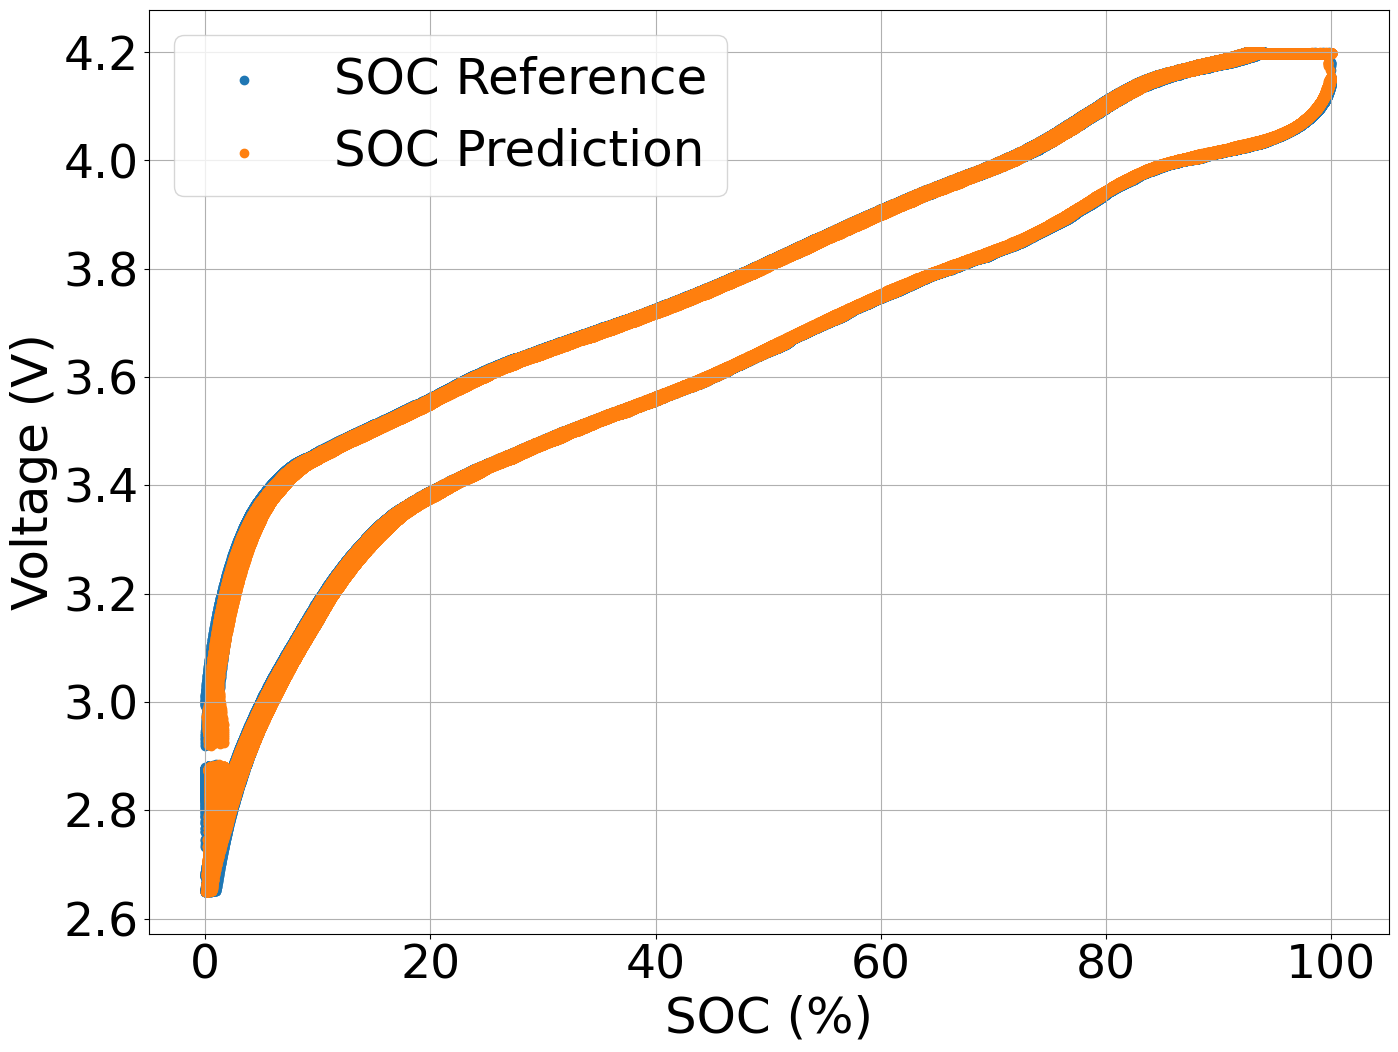

In [9]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(df['SOCref'],df['Voltage'])
plt.scatter(df['SOC_pred'],df['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [10]:
model.save('lstm_model3')

INFO:tensorflow:Assets written to: lstm_model3\assets


### Testing

In [11]:
dt = pd.read_parquet('datavalidasi_8cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,22,2019-03-21 21:58:07.150,0.00,0.00,4.150365,-1.020517,26.0625,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.238670,-0.000000,-0.000000,0.000000,0.0
1,22,2019-03-21 21:58:07.960,0.81,0.81,4.148546,-1.020517,26.0625,0.000230,0.000230,0.000230,0.0,0.001819,0.006753,99.993247,4.236852,-0.000973,-0.000973,0.000973,0.0
2,22,2019-03-21 21:58:08.150,1.00,0.19,4.148183,-1.020517,26.0625,0.000054,0.000283,0.000283,0.0,0.000364,0.008338,99.991662,4.236488,-0.000228,-0.001201,0.001201,0.0
3,22,2019-03-21 21:58:09.160,2.01,1.01,4.147092,-1.020517,26.0625,0.000286,0.000570,0.000570,0.0,0.001091,0.016758,99.983242,4.235397,-0.001213,-0.002414,0.002414,0.0
4,22,2019-03-21 21:58:10.160,3.01,1.00,4.146000,-1.020517,26.0625,0.000283,0.000853,0.000853,0.0,0.001091,0.025096,99.974904,4.234306,-0.001200,-0.003614,0.003614,0.0


In [12]:
from tensorflow.keras.models import load_model
model = load_model('lstm_model3')

In [13]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

6763/6763 [==============================] - 11s 2ms/step


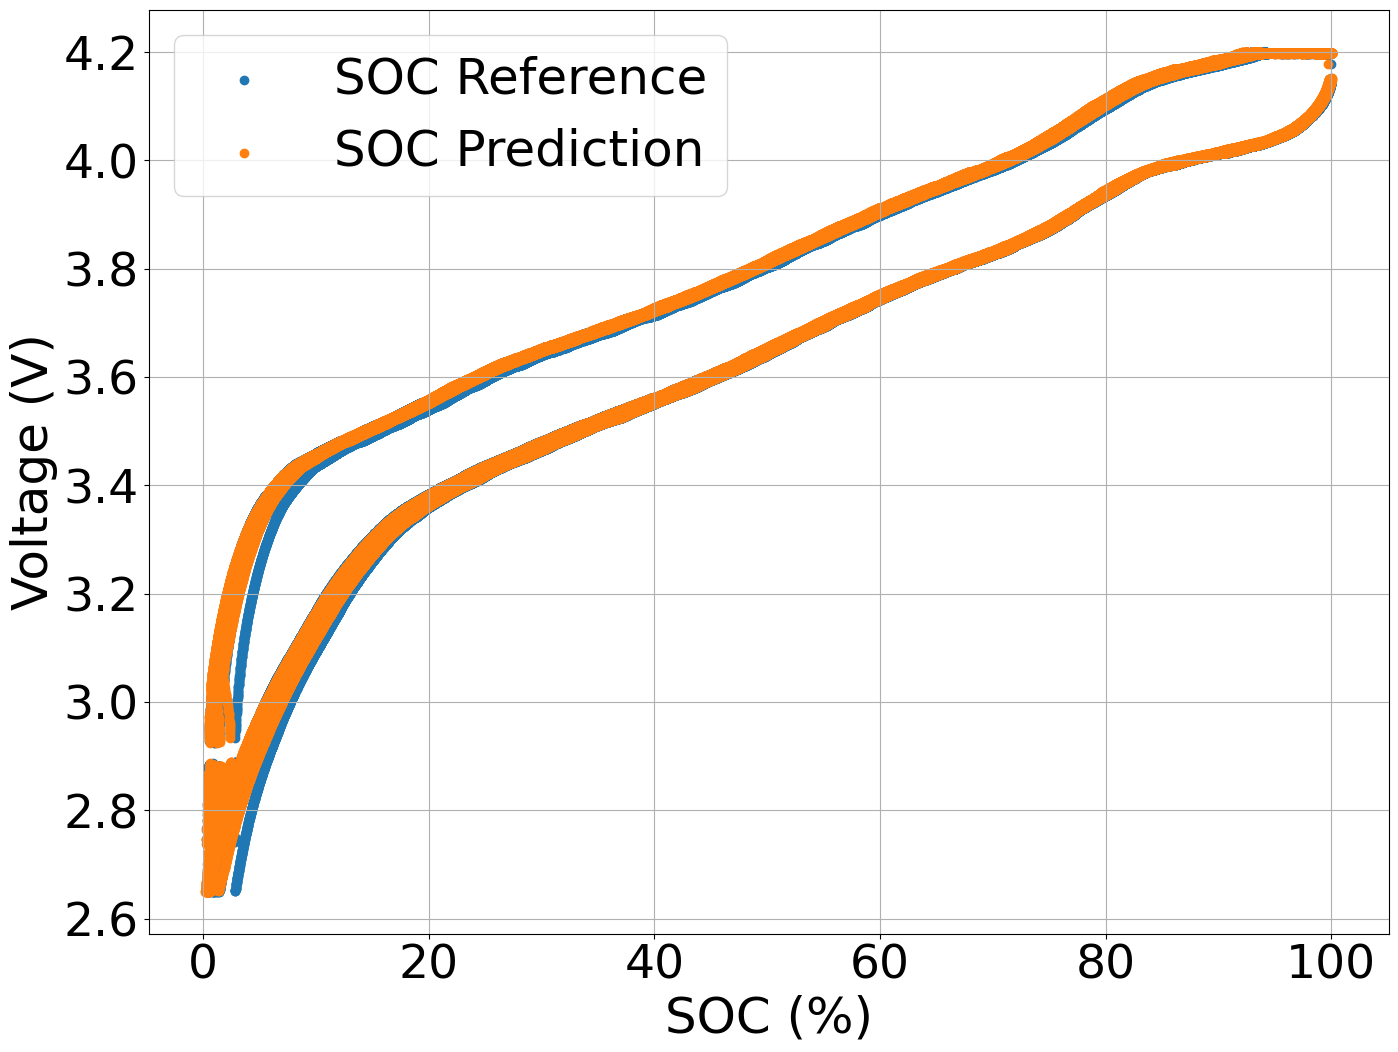

In [14]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCref'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [15]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9997717927010794
RMSE data tes = 0.4456539603925934
MAE  data tes = 0.30887839730853506
MAPE data tes = 1.6826208943458785 %


# Validasi 2

In [16]:
dt = pd.read_parquet('datavalidasi2_1cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh),SOCnorm
0,1,2018-09-06 03:41:33.220,0.00,0.00,4.170733,-0.340172,26.1875,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,4.197950,-0.000000,-0.000000,0.000000,0.0,100.000000
1,1,2018-09-06 03:41:34.240,1.02,1.02,4.170006,-0.340172,26.1875,0.000096,0.000096,0.000096,0.0,0.000727,0.002835,99.997165,4.197223,-0.000405,-0.000405,0.000405,0.0,99.997185
2,1,2018-09-06 03:41:35.240,2.02,1.00,4.169278,-0.340172,26.1875,0.000094,0.000191,0.000191,0.0,0.000727,0.005614,99.994386,4.196496,-0.000397,-0.000801,0.000801,0.0,99.994425
3,1,2018-09-06 03:41:36.220,3.00,0.98,4.168915,-0.340172,26.1875,0.000093,0.000283,0.000283,0.0,0.000364,0.008338,99.991662,4.196132,-0.000389,-0.001190,0.001190,0.0,99.991720
4,1,2018-09-06 03:41:37.240,4.02,1.02,4.168551,-0.340172,26.1875,0.000096,0.000380,0.000380,0.0,0.000364,0.011172,99.988828,4.195768,-0.000404,-0.001594,0.001594,0.0,99.988905


In [17]:
from tensorflow.keras.models import load_model
model = load_model('lstm_model3')

In [18]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

2503/2503 [==============================] - 4s 1ms/step


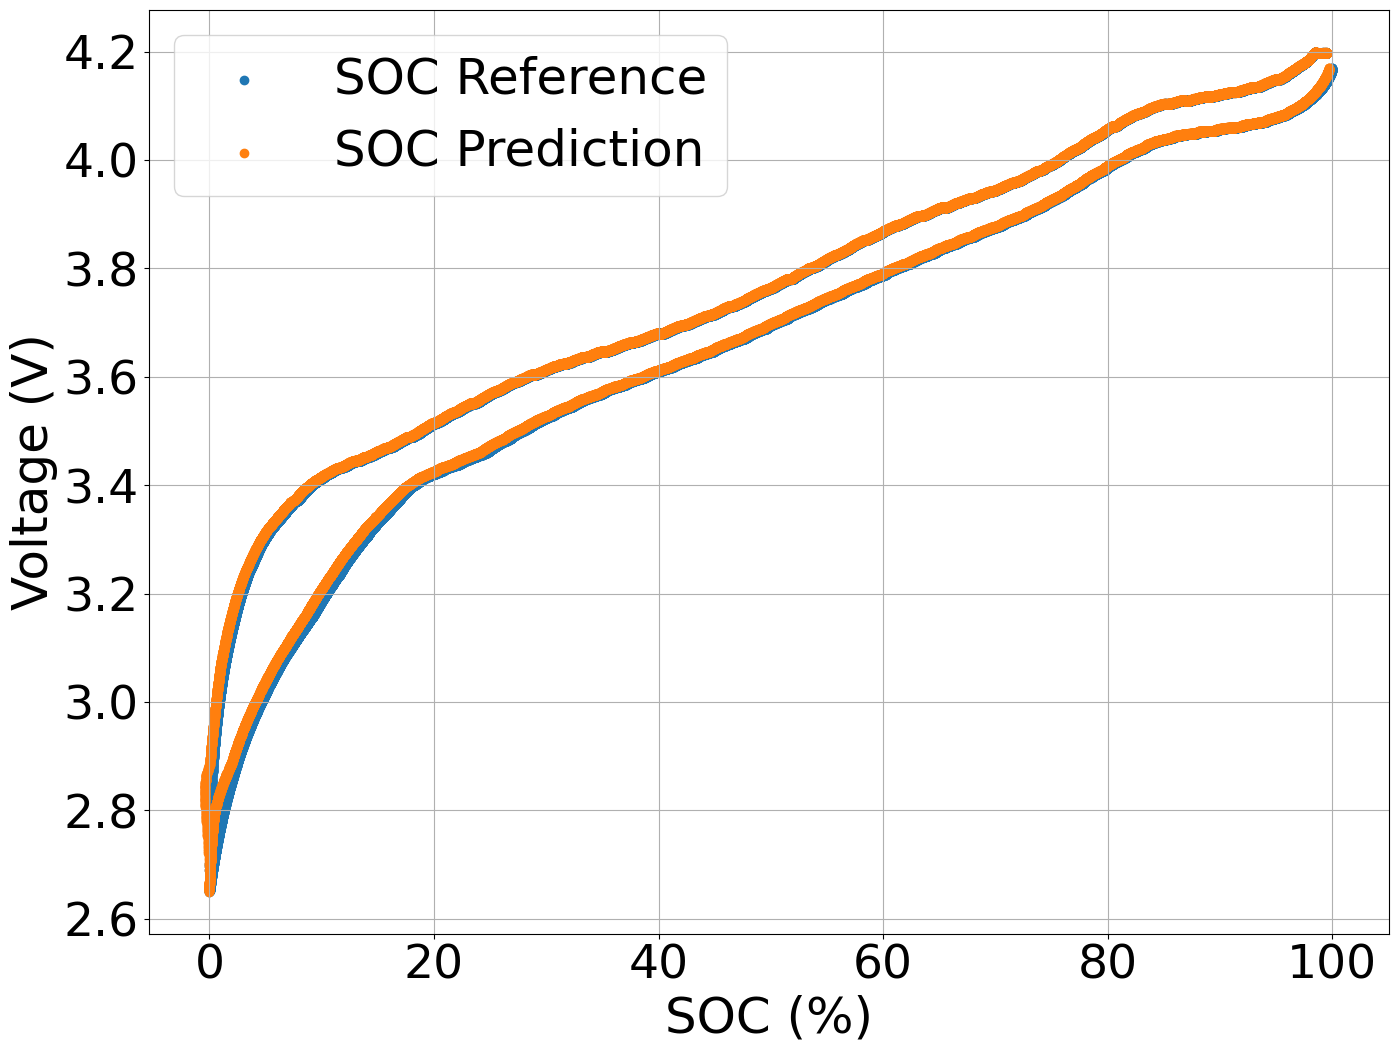

In [19]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCnorm'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [20]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9999664510874301
RMSE data tes = 0.16888089167702483
MAE  data tes = 0.13899815611943545
MAPE data tes = 8.918795981433272 %


# Validasi 3

In [21]:
dt = pd.read_parquet('datavalidasi3_1cyc.parquet')
dt.head()

,Cell,Time,Time (s),dTime,Voltage,Current,Temperature,dCapacity_a,dCapacity_b,discharge capacity (Ah),charge capacity (Ah),deltaV,DOD,SOCref,OCV,dEnergy_a,dEnergy_b,discharge energy (Wh),charge energy (Wh)
0,1,2018-09-17 11:17:37.170,0.00,0.00,4.043151,0.869627,26.25,0.000000,0.000000,2.573356,2.573356,0.000000,0.000000,100.000000,4.005922,0.000000,0.000000,9.737424,9.737424
1,1,2018-09-17 11:17:37.180,0.01,0.01,4.040241,0.765159,26.25,0.000002,0.000002,2.573356,2.573358,0.002909,0.000063,100.000063,4.007485,0.000009,0.000009,9.737424,9.737432
2,1,2018-09-17 11:17:37.200,0.03,0.02,4.040241,0.765159,26.25,0.000004,0.000006,2.573356,2.573363,0.000000,0.000188,100.000188,4.007485,0.000017,0.000026,9.737424,9.737449
3,1,2018-09-17 11:17:37.270,0.10,0.07,4.047878,1.061622,26.25,0.000021,0.000027,2.573356,2.573383,0.007637,0.000795,100.000795,4.002430,0.000083,0.000108,9.737424,9.737532
4,1,2018-09-17 11:17:37.360,0.19,0.09,4.041696,0.804687,26.25,0.000020,0.000047,2.573356,2.573403,0.006182,0.001386,100.001386,4.007247,0.000081,0.000189,9.737424,9.737613


In [22]:
from tensorflow.keras.models import load_model
model = load_model('lstm_model3')

In [24]:
#Xt = dt[['OCV', 'Temperature', 'deltaV', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = dt[['OCV', 'Temperature', 'discharge energy (Wh)', 'charge energy (Wh)']]
Xt = np.array(Xt).reshape(-1, 1, 4)
#Xt = np.array(Xt).reshape(-1, 4)
Yt = dt['SOCref']
Yt = np.array(Yt).reshape(-1, 1)

SOC_pred=model.predict(Xt)
dt['SOC_pred']=SOC_pred
dt['Rel_Err']=abs((dt['SOC_pred']-dt['SOCref'])*100/dt['SOCref'])

1232/1232 [==============================] - 2s 1ms/step


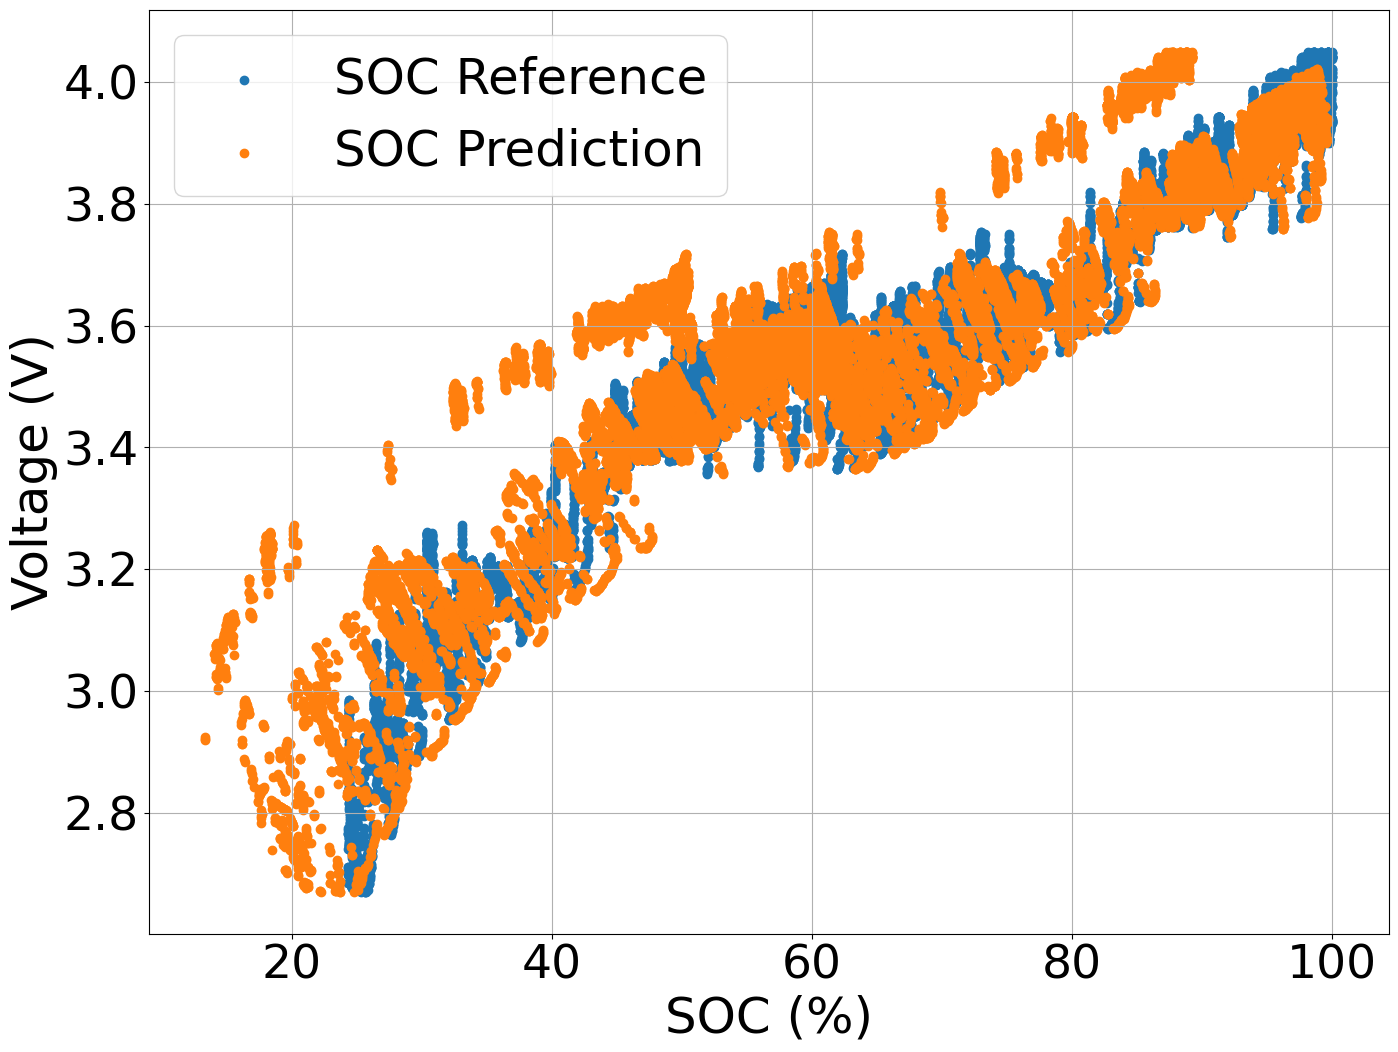

In [25]:
plt.figure(figsize = (16,12))
plt.xlabel('SOC (%)',fontsize=36)
plt.ylabel("Voltage (V)",fontsize=36)
plt.xticks(fontsize=34)
plt.yticks(fontsize=34)
plt.scatter(dt['SOCref'],dt['Voltage'])
plt.scatter(dt['SOC_pred'],dt['Voltage'])
plt.grid()
plt.legend(["SOC Reference","SOC Prediction"], fontsize=36)

In [26]:
r2=r2_score(Yt, SOC_pred)
rmse=np.sqrt(mean_squared_error(Yt,SOC_pred))
MAE=mean_absolute_error(Yt, SOC_pred)
MAPE=mean_absolute_percentage_error(Yt, SOC_pred)

print('R2   data tes =',r2)
print('RMSE data tes =',rmse)
print('MAE  data tes =',MAE)
print('MAPE data tes =',MAPE*100,'%')

R2   data tes = 0.9369686344220992
RMSE data tes = 5.254555167249418
MAE  data tes = 3.1510397814436186
MAPE data tes = 5.335250507375046 %
